In [1]:
import pandas
import os
import sys
from pathlib import Path
import functools
import re

In [2]:
import matplotlib
import matplotlib.pyplot

In [3]:
import sklearn.metrics

In [4]:
root_repo_dir = Path().absolute().parent
sys.path = [os.path.join(root_repo_dir,'dataexploration'),
            os.path.join(root_repo_dir,'classification'),
            os.path.join(root_repo_dir,'preprocessing'),
            os.path.join(root_repo_dir,'metrics'),
           ] + sys.path

In [5]:
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'pangeo'

In [6]:
root_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/',
    'pangeo': '/data/misc/xbt-data/',
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015)
}


In [7]:
# Set up some dataset specific parameters
root_data_dir = root_data_dirs[environment]
year_range = env_date_ranges[environment]

In [8]:
input_dir_name = 'csv_with_imeta'
exp_out_dir_name = 'experiment_outputs'
imeta_dir = 'imeta'

In [9]:
xbt_input_dir = os.path.join(root_data_dir, input_dir_name)
xbt_output_dir = os.path.join(root_data_dir, exp_out_dir_name)
xbt_imeta_path   = os.path.join(root_data_dir, imeta_dir)

## Results from different classifiers

Here we compare the recall metric for the different classifiers used and different input features.

In [10]:
regex_metrics_files = 'xbt_metrics_(?P<classifier>([\w]+))_(?P<features>([\w]+))(_cv)*_(?P<timestamp>[0-9_]+)'

In [11]:
imeta_metrics = pandas.read_csv(os.path.join(xbt_imeta_path, 'xbt_metrics_imeta.csv'))                             

In [12]:
metric_tuples1 = [ (dir_list[0], sorted([fname1 for fname1 in dir_list[2] if 'xbt_metrics' in fname1])[-1]) for dir_list in os.walk(xbt_output_dir) if len([fname1 for fname1 in dir_list[2] if 'xbt_metrics' in fname1]) > 0]
metric_tuples1 = [(i1[0],i1[1], re.search(regex_metrics_files, i1[1])) for i1 in metric_tuples1]

In [13]:
metrics_files_dict = {'{0}_{1}'.format(t1[2].group('classifier'), t1[2].group('features')): 
 {
    'classifier': t1[2].group('classifier'),
    'features': t1[2].group('features'),
    'timestamp': t1[2].group('timestamp'),
    'dir': t1[0],
    'fname': t1[1],
     'path': os.path.join(t1[0], t1[1]),
 }
    for t1 in metric_tuples1}

In [14]:
metrics_list = {k1: pandas.read_csv(v1['path']) for k1, v1 in metrics_files_dict.items()}

In [15]:
metrics_train_perClassifier = {
    k1: pandas.merge(v1[[i1 for i1 in v1.columns if ('_all' in i1 and 'recall_' in i1 and 'train_' in i1) or ('year' == i1)]],
                  pandas.DataFrame({'year': v1['year'], k1 + '_mean': v1[[i1 for i1 in v1.columns if '_all' in i1 and 'recall_' in i1 and 'train_' in i1]].mean(axis=1)})) 
      for k1,v1 in metrics_list.items()}

metrics_test_perClassifier = {
    k1: pandas.merge(v1[[i1 for i1 in v1.columns if ('_all' in i1 and 'recall_' in i1 and 'test_' in i1) or ('year' == i1)]],
                  pandas.DataFrame({'year': v1['year'], k1 + '_mean': v1[[i1 for i1 in v1.columns if '_all' in i1 and 'recall_' in i1 and 'test_' in i1]].mean(axis=1)})) 
      for k1,v1 in metrics_list.items()}


In [16]:
metrics_cons_train1 = functools.reduce(lambda df1,df2: pandas.merge(df1,df2,on='year'), 
       [pandas.DataFrame({'year': v1['year'], k1: v1[[i1 for i1 in v1.columns if '_all' in i1 and 'recall_' in i1 and 'train_' in i1]].mean(axis=1)}) 
      for k1,v1 in metrics_list.items()]) 
metrics_cons_test1 = functools.reduce(lambda df1,df2: pandas.merge(df1,df2,on='year'), 
       [pandas.DataFrame({'year': v1['year'], k1: v1[[i1 for i1 in v1.columns if '_all' in i1 and 'recall_' in i1 and 'test_' in i1]].mean(axis=1)}) 
      for k1,v1 in metrics_list.items()]) 

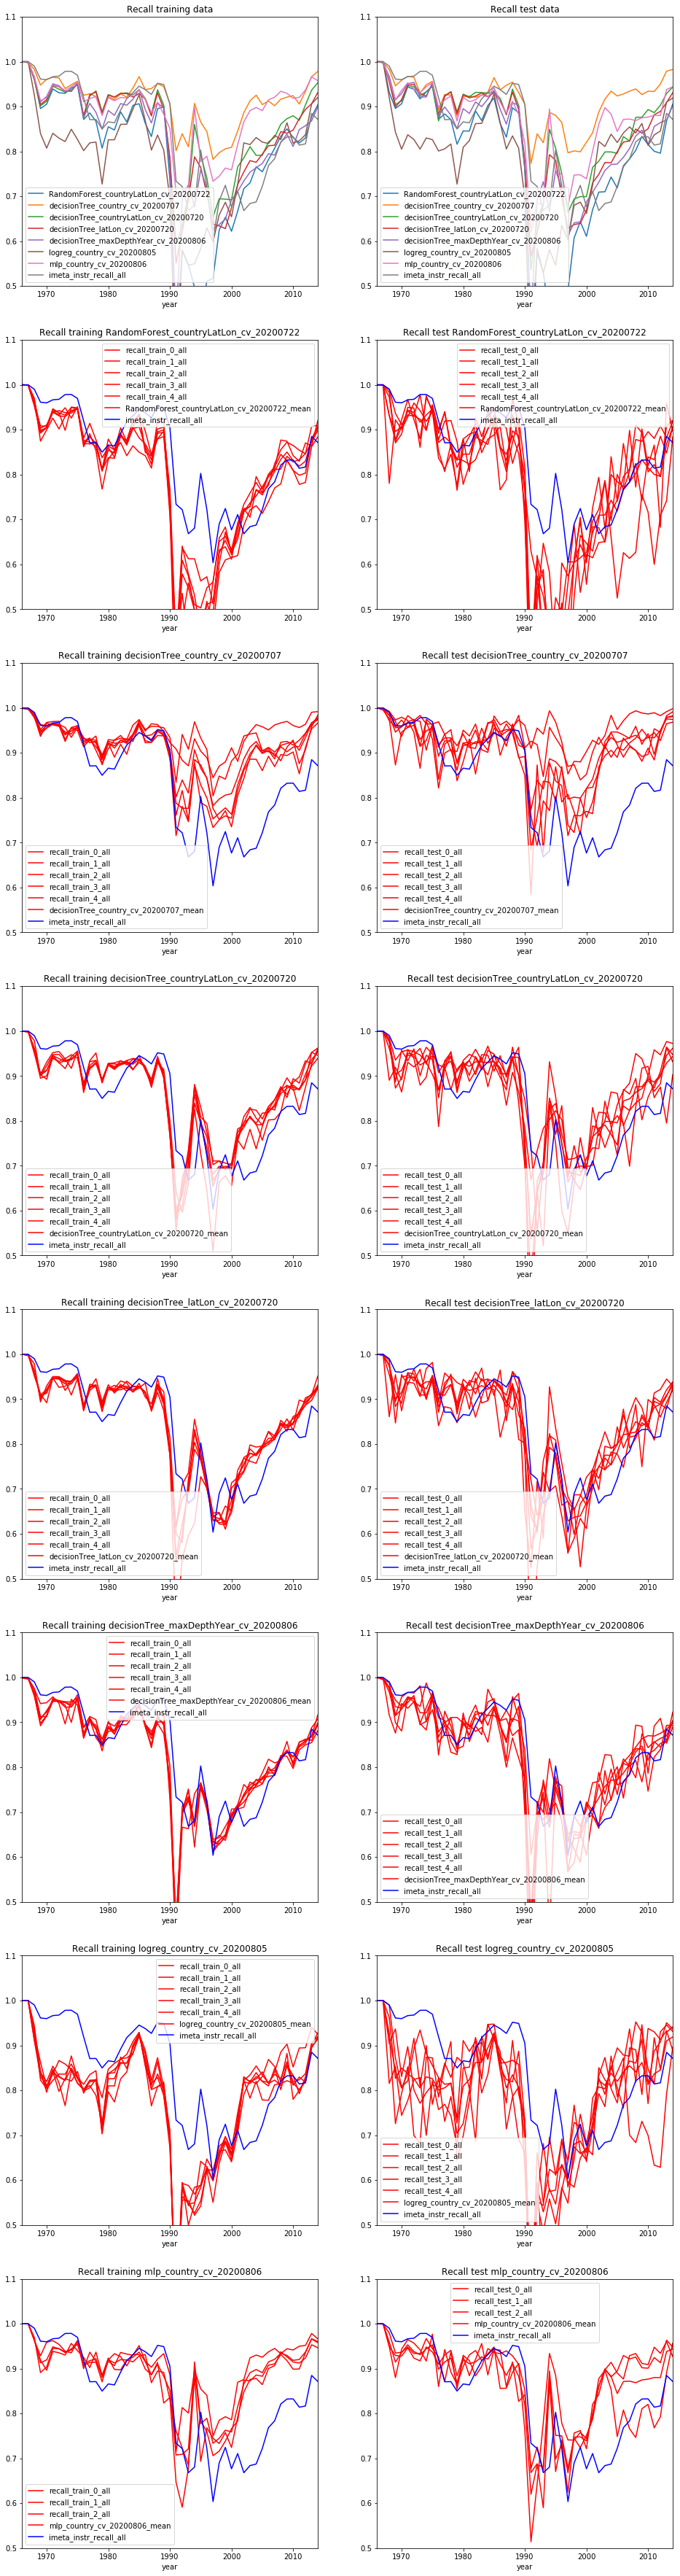

In [17]:
num_rows = len(metrics_cons_train1.keys())
ylim = [0.5,1.1]

fig_results = matplotlib.pyplot.figure('results1', figsize=(16, 8*(num_rows+1)))
ax_train = fig_results.add_subplot(num_rows+1, 2, 1, title='Recall training data')
metrics_cons_train1.plot.line(x='year', ax=ax_train, ylim=ylim)
ax_test = fig_results.add_subplot(num_rows+1, 2, 2, title='Recall test data')
metrics_cons_test1.plot.line(x='year', ax=ax_test, ylim=ylim)

imeta_metrics.plot.line(x='year',y='imeta_instr_recall_all', ax=ax_train, ylim=ylim)
imeta_metrics.plot.line(x='year',y='imeta_instr_recall_all', ax=ax_test, ylim=ylim)

ix1 = 1
for k1, v1 in metrics_train_perClassifier.items():
    ax_train = fig_results.add_subplot(num_rows+1, 2 , ix1*2 + 1, title='Recall training {0}'.format(k1))
    v1.plot.line(x='year', ax=ax_train, ylim=[0.5,1.1],c='r')
    imeta_metrics.plot.line(x='year',y='imeta_instr_recall_all', ax=ax_train, ylim=ylim, c='b')
    ix1 += 1
ix1 = 1    
for k1, v1 in metrics_test_perClassifier.items():
    ax_test = fig_results.add_subplot(num_rows+1, 2, ix1*2 + 2, title='Recall test {0}'.format(k1))
    v1.plot.line(x='year', ax=ax_test, ylim=[0.5,1.1],c='r')
    imeta_metrics.plot.line(x='year',y='imeta_instr_recall_all', ax=ax_test, ylim=ylim,c='b')
    ix1 += 1
    


What graphs and tables do we want to show here to justify our decision of which classifier type and what set of input features we are recommending to use?

* averages for each classifier
* show all member, average and max prob metrics for each classifier
* compare to imeta baseline for each
* come up with one number for each classifier to choose the best classifier.

Other questions:
* Do we want to compare per class performance
* more analysis of per cruise performance